This script is meant to find the hilbert transform envelope of the audio signal. It creates a csv file with true and estiamted param of PEF, FEV1 and FVC. The csv is further used in the ML pipeline

In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.io import wavfile # package to read WAV file
import pandas as pd
sns.set_style("white")
sns.set_style("ticks")
import warnings
warnings.filterwarnings("ignore")
import latexify as lt
import librosa
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import json
import matplotlib.pyplot as plt # matplot lib is the premiere plotting lib for Python: https://matplotlib.org/
import numpy as np # numpy is the premiere signal handling library for Python: http://www.numpy.org/
import scipy as sp # for signal processing
from scipy import signal
from scipy.io import wavfile

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import Audio

#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;

In [2]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [3]:
#execute one time only
data = pd.DataFrame(
    {'Name': [],
     'Filename':[],
     'rPEF': [],
     'rFEV1': [],
     'rFVC': [],
     'rRatio':[],
     'gPEF': [],
     'gFEV1': [],
     'gFVC': [],
     'gRatio':[]
    })
data.to_csv('data_FVC_N95.csv')

File P0.FVC_N95.LCL.2dbk4ib2.wav found
Processing Hilbert Transformation . . .

Completed Writing data to dataframe
File P1.FVC_N95.2blk7k0f.wav found
Processing Hilbert Transformation . . .

Completed Writing data to dataframe
File P2.FVC_N95.2blk7k0f.wav found
Processing Hilbert Transformation . . .

Completed Writing data to dataframe
File P3.FVC_N95.LCL.amiramir.wav found
Processing Hilbert Transformation . . .

Completed Writing data to dataframe
File P4.FVC_N95.RCL.2dbj63ol.wav found
Processing Hilbert Transformation . . .

Completed Writing data to dataframe
File P5.FVC_N95.LCL.2dbjkojc.wav found
Processing Hilbert Transformation . . .

Completed Writing data to dataframe
File P6.FVC_N95.RCL.2dbha71f.wav found
Processing Hilbert Transformation . . .

Completed Writing data to dataframe
File P9.FVC_N95.2bldi9ts.wav found
Processing Hilbert Transformation . . .

Completed Writing data to dataframe
File P10.FVC_N95.2bldi9ts.wav found
Processing Hilbert Transformation . . .

Complet

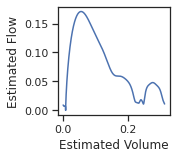

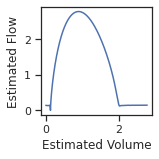

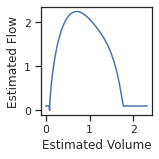

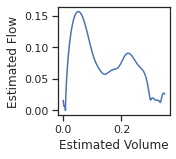

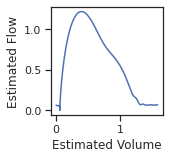

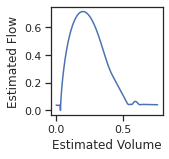

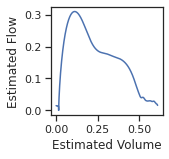

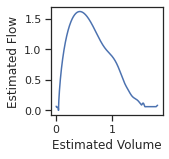

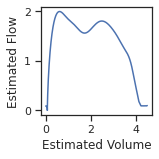

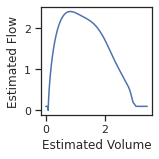

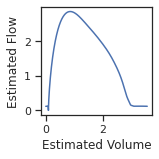

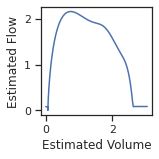

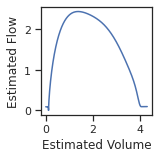

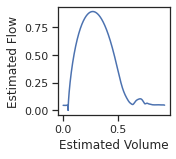

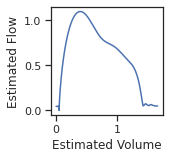

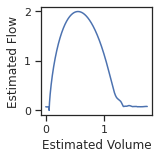

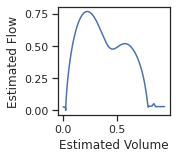

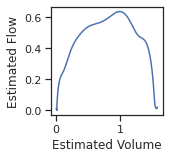

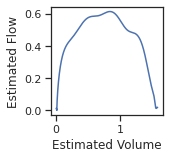

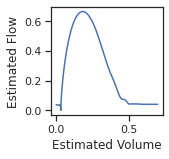

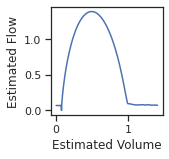

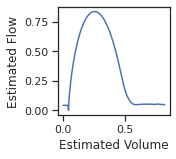

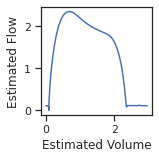

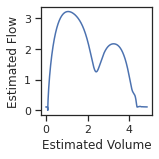

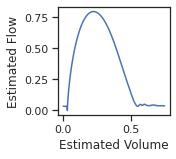

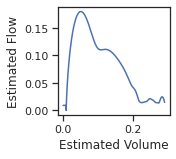

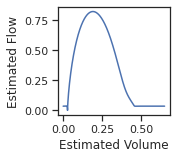

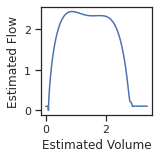

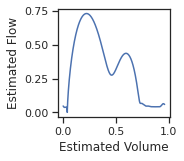

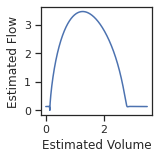

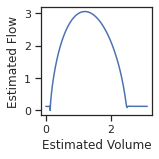

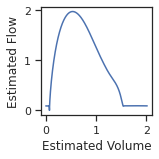

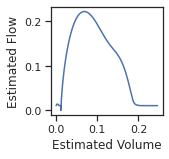

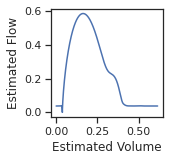

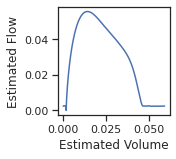

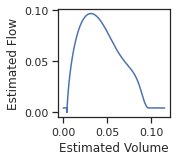

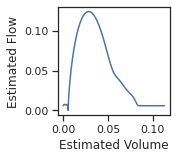

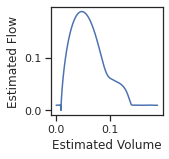

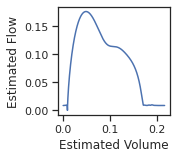

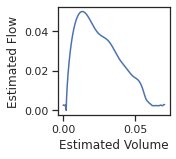

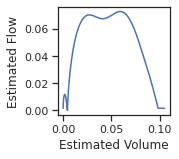

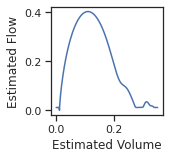

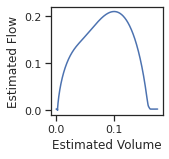

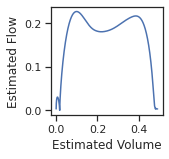

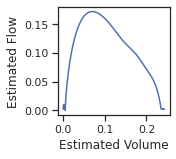

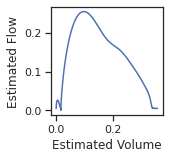

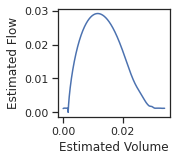

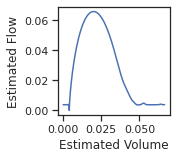

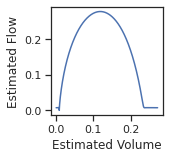

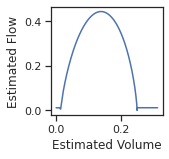

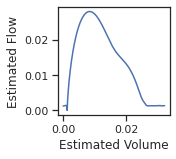

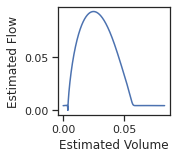

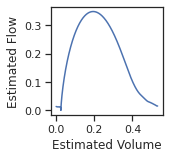

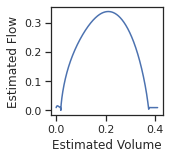

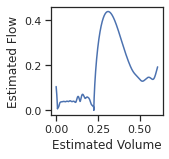

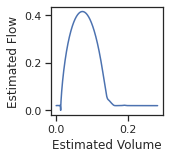

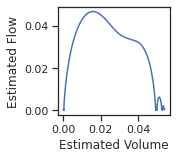

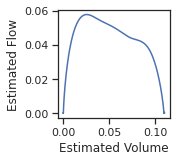

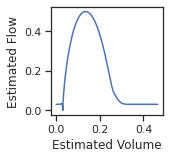

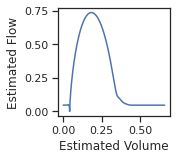

In [4]:
import os
#read the ground truth file
#open the file where the measured values present
# ****************** EDITED ********************
try: 
    measured = pd.read_csv('data-forced-breathing-1/GT_FB_N95.csv', index_col='Unnamed: 0')
except:
    measured = pd.read_csv('data-forced-breathing-1/GT_FB_N95.csv')

#select path where audio data is stored
# ****************** EDITED ********************
mypath="data-forced-breathing-1/N95/"
(_, _, filenames) = next(os.walk(mypath))
names = [file.split('.')[0] for file in filenames]
#read the csv where final computed data is stored
df = pd.read_csv('data_FVC_N95.csv')


#read the ground truth file
for i in range(len(measured['UID'])):
    fig,ax = plt.subplots(1,1,figsize=(2,2))
    #if the dataframe already contains the name then dont do anything
    if df['Name'].str.contains(measured['UID'][i]).sum() > 0:
        print("Entry for Name {} already exists, moving to next file".format(measured['UID'][i]))
        continue;
    else:
        try:
            file = filenames[names.index(measured['UID'][i])]
            print("File {} found".format(file))
            #store ground truth data
            gPEF = measured['gPEF'][i]
            gFEV1 = measured['gFEV1'][i]
            gFVC = measured['gFVC'][i]
            gRatio = gFEV1/gFVC*100

            print('Processing Hilbert Transformation . . .\n')
            #calculate predictions base on HT
            if (mypath+file).endswith('.wav'):
                x, fs = librosa.load(mypath+file, sr=None)
            else:
                print(".wav not found, searching for .json file\n\n")
                with open(mypath+file) as fp:
                    input_data = json.load(fp)
                x = np.array(input_data['payload']['values'])
                fs = 1000/input_data['payload']['interval_ms']
            t = np.arange(0,len(x))/fs
            cutoff_low = 3000 # desired cutoff frequency of the filter, Hz
            cutoff_high = 5000
            order = 10

            #x_filt = butter_highpass_filter(x, cutoff, fs, order)
            x_filt = butter_bandpass_filter(x,cutoff_low,cutoff_high,fs,order)
            x_filt_hilbert = signal.hilbert(x_filt)
            envelope_hat = np.abs(x_filt_hilbert)
            #filter the Hilbert envelope
            nyq_rate = fs /0.5
            width = 1.0/nyq_rate # 5 Hz filter transition width.
            ripple_db = 10.0 # stop band attenuation
            fL_hz = 10
            N, beta = signal.kaiserord(ripple_db, width)
            taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
            envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
            t = np.arange(0,len(envelope_hat_filt))/fs

            #at this point we have the 
            #scale the envelope is estimate of flow rate. We will scale this to match actual flow range
            envelope_hat_filt = np.interp(envelope_hat_filt, (envelope_hat_filt.min(), 1), (0, 8))
            rPEF = round(envelope_hat_filt.max(),2)

            estdVolume = np.cumsum(envelope_hat_filt)
            estdVolume = np.interp(estdVolume, (0, np.cumsum([1]*len(t)).max()), (0, 8))
            #FEV1 Estimate
            rFEV1 = round(estdVolume[np.where(t==1)[0][0]],2)
            #FVC Estimate
            rFVC = round(estdVolume[-1],2)

            rRatio = (rFEV1/rFVC)*100


            row = {'Name': measured['UID'][i], 'Filename':file, 'rPEF': rPEF, 'rFEV1': rFEV1, 'rFVC':rFVC, 'rRatio': rRatio, 'gPEF': gPEF, 'gFEV1': gFEV1, 'gFVC':gFVC, 'gRatio': gRatio}
            df = df.append(row, ignore_index = True)
            print('Completed Writing data to dataframe')
            #estdVolume = estdVolume/np.max(estdVolume)
            ax.plot(estdVolume, envelope_hat_filt)
            ax.set_xlabel('Estimated Volume')
            ax.set_ylabel('Estimated Flow')
        except:
            print("Error with = {}".format(measured['UID'][i]))
            continue;


In [5]:
df.to_csv('data_FVC_N95.csv', index=False)

### Save the HT envelope information in a pickle file

In [13]:
import os
#read the ground truth file
#open the file where the measured values present
# ****************** EDITED ********************
try: 
    measured = pd.read_csv('data-forced-breathing-1/GT_FB_N95.csv', index_col='Unnamed: 0')
except:
    measured = pd.read_csv('data-forced-breathing-1/GT_FB_N95.csv')

#select path where audio data is stored
# ****************** EDITED ********************
mypath="data-forced-breathing-1/N95/"
(_, _, filenames) = next(os.walk(mypath))
names = [file.split('.')[0] for file in filenames]


di = {}

for file in filenames:
    if (mypath+file).endswith('.wav'):
        x, fs = librosa.load(mypath+file, sr=None)
    else:
        with open(mypath+file) as fp:
            input_data = json.load(fp)
        x = np.array(input_data['payload']['values'])
        fs = 1000/input_data['payload']['interval_ms']
    t = np.arange(0,len(x))/fs
    cutoff_low = 3000 # desired cutoff frequency of the filter, Hz
    cutoff_high = 5000
    order = 5

    #x_filt = butter_highpass_filter(x, cutoff, fs, order)
    x_filt = butter_bandpass_filter(x,cutoff_low,cutoff_high,fs,order)
    x_filt_hilbert = signal.hilbert(x_filt)
    envelope_hat = np.abs(x_filt_hilbert)
    #filter the Hilbert envelope
    nyq_rate = fs /0.5
    width = 1.0/nyq_rate # 5 Hz filter transition width.
    ripple_db = 10.0 # stop band attenuation
    fL_hz = 10
    N, beta = signal.kaiserord(ripple_db, width)
    taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
    envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
    t = np.arange(0,len(envelope_hat_filt))/fs

    #at this point we have the 
    #scale the envelope is estimate of flow rate. We will scale this to match actual flow range
    envelope_hat_filt = np.interp(envelope_hat_filt, (envelope_hat_filt.min(), 1), (0, 8))
    
    di[file] = envelope_hat_filt



In [22]:
import tsfel
import pickle
def getTSfeatures(data):
    cfg = tsfel.get_features_by_domain('temporal') #temporal, spectral, statistical
    stat_features = np.array(tsfel.time_series_features_extractor(cfg, data, fs=16000, window=300))[0]
    return stat_features

In [23]:
envelopeTSf = {}
for key in di:
    try:
        envelopeTSf[key] = getTSfeatures(di[key])
        print("Done for = {}".format(key))
    except:
        print("Failed For {}".format(key))

*** Feature extraction started ***
18


Done for = P16.FVC_N95.RCL.2dbikf27.wav
*** Feature extraction started ***
18


Done for = P12.FVC_N95.2b66lj8n.wav
*** Feature extraction started ***
18


Done for = P3.FVC_N95.LCL.amiramir.wav
*** Feature extraction started ***
18


Done for = P13.FVC_N95.2bllj08r.wav
*** Feature extraction started ***
18


Done for = P47.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P42.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P55.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P58.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P32.FVC_N95.2c29ernu.wav
*** Feature extraction started ***
18


Done for = P19.FVC_N95.2bqkp33h.wav
*** Feature extraction started ***
18


Done for = P59.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P43.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P23.FVC_N95.LCL.2dbeochp.wav
*** Feature extraction started ***
18


Done for = P14.FVC_N95.2bllk1ud.wav
*** Feature extraction started ***
18


Done for = P15.FVC_N95.RCL.skjfhsi.wav
*** Feature extraction started ***
18


Done for = P38.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P0.FVC_N95.LCL.2dbk4ib2.wav
*** Feature extraction started ***
18


Done for = P54.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P1.FVC_N95.2blk7k0f.wav
*** Feature extraction started ***
18


Done for = P5.FVC_N95.LCL.2dbjkojc.wav
*** Feature extraction started ***
18


Done for = P28.FVC_N95.2aa5vpa8.wav
*** Feature extraction started ***
18


Done for = P11.FVC_N95.2b66msvi.wav
*** Feature extraction started ***
18


Done for = P27.FVC_N95.RCL.2dbiad4s.wav
*** Feature extraction started ***
18


Done for = P62.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P17.FVC_N95.2b8ki4jm.wav
*** Feature extraction started ***
18


Done for = P52.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P49.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P60.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P29.FVC_N95.2bb8mr8l.wav
*** Feature extraction started ***
18


Done for = P20.FVC_N95.2bqkq12o.wav
*** Feature extraction started ***
18


Done for = P44.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P7.FVC_N95.2be0sr3s.wav
*** Feature extraction started ***
18


Done for = P36.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P40.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P53.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P10.FVC_N95.2bldi9ts.wav
*** Feature extraction started ***
18


Done for = P8.FVC_N95.2be0uvo6.wav
*** Feature extraction started ***
18


Done for = P34.FVC_N95.2c02a3vr.wav
*** Feature extraction started ***
18


Done for = P22.FVC_N95.LCL.asswerf.wav
*** Feature extraction started ***
18


Done for = P2.FVC_N95.2blk7k0f.wav
*** Feature extraction started ***
18


Done for = P4.FVC_N95.RCL.2dbj63ol.wav
*** Feature extraction started ***
18


Done for = P41.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P51.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P61.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P31.FVC_N95.2c29e4tp.wav
*** Feature extraction started ***
18


Done for = P48.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P18.FVC_N95.2b8kj7lr.wav
*** Feature extraction started ***
18


Done for = P30.FVC_N95.2c1thc3n.wav
*** Feature extraction started ***
18


Done for = P46.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P24.FVC_N95.2bda6hnu.wav
*** Feature extraction started ***
18


Done for = P25.FVC_N95.2b6bnd0l.wav
*** Feature extraction started ***
18


Done for = P39.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P26.FVC_N95.RCL.2dbg34vu.wav
*** Feature extraction started ***
18


Done for = P57.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P21.FVC_N95.LCL.2dbiqh7s.wav
*** Feature extraction started ***
18


Done for = P63.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P9.FVC_N95.2bldi9ts.wav
*** Feature extraction started ***
18


Done for = P50.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P33.FVC_N95.2b8n0616.wav
*** Feature extraction started ***
18


Done for = P45.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P35.FVC_N95.2c02b089.wav
*** Feature extraction started ***
18


Done for = P6.FVC_N95.RCL.2dbha71f.wav
*** Feature extraction started ***
18


Done for = P56.FVC_N95.added.wav
*** Feature extraction started ***
18


Done for = P37.FVC_N95.added.wav


In [21]:
#assign zeros for files whose stat features could not be generated
#envelopeTSf['P19.FVC_C.2bql8pcq.wav'] = np.zeros(390)

In [24]:
with open('FVC-HT-Envelope-TEMPORAL.pickle', 'wb') as handle:
    pickle.dump(envelopeTSf, handle, protocol=pickle.HIGHEST_PROTOCOL)